In [1]:
import os
os.chdir('../..')
import numpy as np
import torch
import pickle
from tqdm import tqdm
from rdkit.Chem import MolFromInchi
from rdkit.Chem.rdmolops import Kekulize
from sklearn.model_selection import KFold


RDKit WARNING: [17:18:50] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from molgrad.utils import DATA_PATH, EXAMPLE_PATH, MODELS_PATH
from molgrad.vis import molecule_importance
from molgrad.net import MPNNPredictor
from molgrad.train import DEVICE, SEED, N_FOLDS

Using backend: pytorch


In [3]:
FOLD_NO = 5

with open(os.path.join(DATA_PATH, "cyp", "data_cyp.pt"), "rb") as handle:
            inchis, values = pickle.load(handle)

inchis = np.array(inchis)
values = np.array(values)[:, np.newaxis]

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
_, idx_test =  list(kf.split(inchis))[FOLD_NO]

inchis, values = inchis[idx_test].tolist(), values[idx_test, :].squeeze().tolist()


In [4]:
sim = np.load(os.path.join(DATA_PATH, "cyp", f"sim_cyp_fold{FOLD_NO}.npy"))
preds = np.load(os.path.join(DATA_PATH, "cyp", f"preds_fold{FOLD_NO}.npy"))
diff_true = np.load(os.path.join(DATA_PATH, "cyp", f"diff_exp_fold{FOLD_NO}.npy"))
diff_hat = np.load(os.path.join(DATA_PATH, "cyp", f"diff_hat_fold{FOLD_NO}.npy"))

In [5]:
sim.shape

(912, 912)

In [6]:
diff_true.shape

(912, 912)

In [7]:
diff_hat.shape

(912, 912)

In [8]:
preds.shape

(912,)

In [9]:
len(inchis)

912

In [10]:
ligand_i = []
ligand_j = []
values_i = []
values_j = []
preds_i = []
preds_j = []

long_sim = []
long_true = []
long_hat = []

for idx_i, (inchi_i, exp_i, pred_i) in enumerate(zip(inchis, values, preds)):
    for idx_j, (inchi_j, exp_j, pred_j) in enumerate(zip(inchis, values, preds)):
        if idx_i < idx_j:
            ligand_i.append(inchi_i)
            ligand_j.append(inchi_j)
            values_i.append(exp_i)
            values_j.append(exp_j)
            preds_i.append(pred_i)
            preds_j.append(pred_j)
            long_sim.append(sim[idx_i, idx_j])
            long_true.append(diff_true[idx_i, idx_j])
            long_hat.append(diff_hat[idx_i, idx_j])

In [11]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

df_pairs = pd.DataFrame({'inchi_i': ligand_i,
                         'inchi_j': ligand_j,
                         'values_i': values_i,
                         'values_j': values_j,
                         'preds_i': preds_i,
                         'preds_j': preds_j,
                         'similarity': long_sim,
                         'diff_exp': long_true,
                         'diff_pred': long_hat})


In [12]:
def sali_index(sim, diff):
    return np.abs(diff) / (1 - sim)

In [13]:
df_pairs = df_pairs.loc[df_pairs['similarity'] < 1.0]
df_pairs['sali_exp'] = sali_index(df_pairs['similarity'], df_pairs['diff_exp'])
df_pairs['sali_pred'] = sali_index(df_pairs['similarity'], df_pairs['diff_pred'])
df_pairs.sort_values('sali_pred', ascending=False, inplace=True)
df_pairs.reset_index(inplace=True)

In [14]:
df_pairs.head(n=200)

,index,inchi_i,inchi_j,values_i,values_j,preds_i,preds_j,similarity,diff_exp,diff_pred,sali_exp,sali_pred
0,58005,InChI=1S/C19H25N5O2/c1-23(2)19(25)16-5-3-15(4-...,InChI=1S/C18H25N5O/c1-22(2)16-5-3-15(4-6-16)17...,1.0,1.0,1.749019e-06,9.998001e-01,0.790123,0.0,-0.999798,0.000000,4.763746
1,394580,InChI=1S/C22H30N2O8/c1-2-24-21(28)15-6-5-14-16...,InChI=1S/C25H34N2O9/c28-14(11-33-13-16-4-2-8-3...,0.0,0.0,1.495956e-01,9.033040e-01,0.787037,0.0,-0.753708,0.000000,3.539153
2,266317,InChI=1S/C31H30N2O6/c34-26-17-25(32-38-18-19-8...,InChI=1S/C29H30N2O6/c1-2-3-7-15-36-30-23-17-24...,0.0,1.0,4.401621e-03,9.789922e-01,0.724409,-1.0,-0.974591,3.628572,3.536372
3,247744,InChI=1S/C21H26N4O3/c1-15-18(16(2)28-23-15)19(...,InChI=1S/C22H25N5O3/c1-15-19(16(2)30-25-15)20(...,1.0,1.0,7.539580e-01,6.442358e-04,0.774194,0.0,0.753314,0.000000,3.336104
4,353145,InChI=1S/C19H13ClN4O2/c1-26-15-8-6-14(7-9-15)2...,InChI=1S/C17H12N4O2S/c1-23-12-6-4-11(5-7-12)21...,1.0,0.0,2.371892e-02,9.999337e-01,0.686047,1.0,-0.976215,3.185185,3.109425
5,279977,InChI=1S/C20H19N5OS/c1-24(2)20-21-13-15-18(23-...,InChI=1S/C23H24N6OS/c1-27-11-13-28(14-12-27)23...,0.0,1.0,1.560445e-03,9.988465e-01,0.673267,-1.0,-0.997286,3.060606,3.052300
6,131947,InChI=1S/C22H28N4O3/c1-16-19(17(2)29-24-16)20(...,InChI=1S/C22H25N5O3/c1-15-19(16(2)30-25-15)20(...,0.0,1.0,9.704397e-01,6.442358e-04,0.680000,-1.0,0.969796,3.125000,3.030611
7,369123,InChI=1S/C21H15ClN6O/c22-15-9-7-14(8-10-15)18-...,InChI=1S/C22H18N6O2/c1-30-11-10-28-20-18(14-24...,0.0,1.0,8.963670e-04,9.986425e-01,0.660194,-1.0,-0.997746,2.942857,2.936224
8,3117,InChI=1S/C24H25N5O/c1-28(2)24-25-17-21-22(27-2...,InChI=1S/C20H19N5OS/c1-24(2)20-21-13-15-18(23-...,1.0,0.0,9.909548e-01,1.560445e-03,0.650000,1.0,0.989394,2.857143,2.826841
9,244871,InChI=1S/C30H40N2O5/c1-18(2)9-8-10-19(3)15-16-...,InChI=1S/C25H30N2O5/c1-3-4-8-13-32-26-19-14-20...,1.0,1.0,3.936286e-03,8.885543e-01,0.678261,0.0,-0.884618,0.000000,2.749488


In [15]:
model_pt = os.path.join(MODELS_PATH, f'cyp_noHs_fold{FOLD_NO}.pt')

model = MPNNPredictor(node_in_feats=49,
                      edge_in_feats=10,
                      global_feats=4,
                      n_tasks=1,
                      output_f=torch.sigmoid).to(DEVICE) 
model.load_state_dict(torch.load(model_pt,
                                 map_location=DEVICE))

<All keys matched successfully>

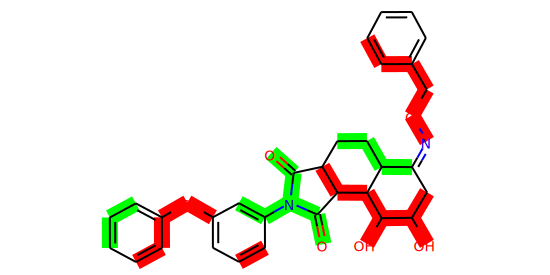

In [16]:
inchi_i, inchi_j = df_pairs.loc[2, 'inchi_i'],  df_pairs.loc[2, 'inchi_j']
mol_i, mol_j = MolFromInchi(inchi_i), MolFromInchi(inchi_j)
#Kekulize(mol_i)
#Kekulize(mol_j)
svg, img, _, _, global_importance = molecule_importance(mol_i,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=0,
                                                      addHs=False,
                                                      img_height=275,
                                                      img_width=550)
img

In [17]:
with open(os.path.join(EXAMPLE_PATH, "cyp_cliff_oof_neg.svg"), "w+") as handle:
    handle.write(svg)

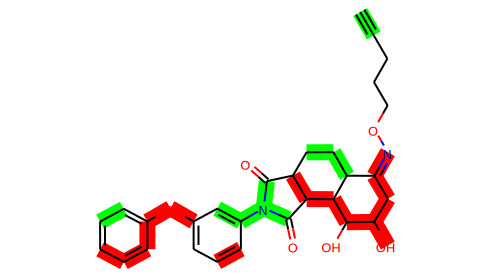

In [18]:
svg, img, _, _, global_importance = molecule_importance(mol_j,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-4,
                                                      addHs=False,
                                                      img_height=275,
                                                      img_width=500)
img

In [19]:
with open(os.path.join(EXAMPLE_PATH, "cyp_cliff_oof_pos.svg"), "w+") as handle:
    handle.write(svg)